In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
dataset=tf.keras.utils.image_dataset_from_directory(
            'PlantVillage',
            labels='inferred',
            label_mode='int',
            #class_names=None,
            color_mode='rgb',
            batch_size=32,
            image_size=(256, 256),
            shuffle=True,
            seed=None,
            validation_split=None,
            subset=None,
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False,
        )

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

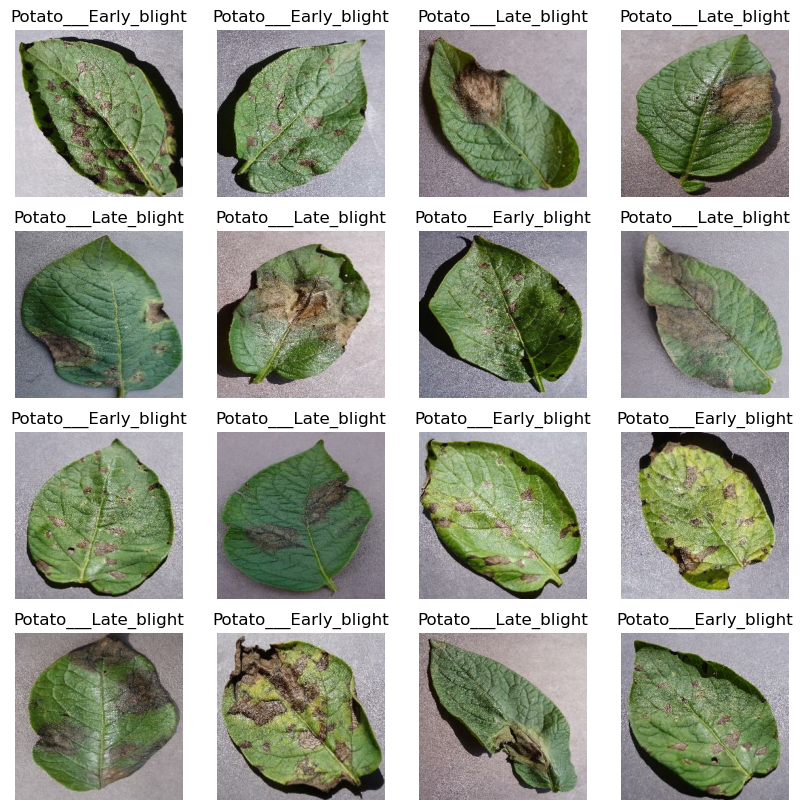

In [5]:
plt.figure(figsize=(10,10))
for img_batch , label_batch  in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

In [6]:
len(dataset)

68

In [7]:
train_size =0.8
len(dataset) * train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test = dataset.skip(54)
len(test)

14

In [11]:
val_ds = test.take(6)
len(val_ds)

6

In [12]:
test_ds = test.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_split(ds, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle = True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 42)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds, test_ds
    


In [14]:
train_ds , val_ds, test_ds = get_dataset_split(dataset)

In [15]:
print(len(train_ds),len(val_ds),len(test_ds), sep='\n')

54
6
8


### Cache, Shuffle and Prefetch the Dataset

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

###     Resizing and Normalizing the Dataset
   

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])

In [18]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=42),
    layers.RandomRotation(0.2)
])

### Model Building

In [19]:
model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, kernel_size=3, activation='relu',input_shape= (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='softmax')
])

model.build((32,256,256,3))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

### Compiling the Model

In [21]:
model.compile(optimizer='adam',
             loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [22]:
history = model.fit(train_ds,
                   batch_size=32,
                   validation_data=val_ds,
                   verbose=1,
                   epochs=50
                   )

Epoch 1/50
54/54 [==============================] - 44s 749ms/step - loss: 1.4724 - accuracy: 0.4302 - val_loss: 0.9188 - val_accuracy: 0.5208
Epoch 2/50
54/54 [==============================] - 50s 937ms/step - loss: 0.9302 - accuracy: 0.4988 - val_loss: 0.8204 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 51s 951ms/step - loss: 0.7936 - accuracy: 0.6332 - val_loss: 0.6352 - val_accuracy: 0.7396
Epoch 4/50
54/54 [==============================] - 53s 985ms/step - loss: 0.5775 - accuracy: 0.7793 - val_loss: 0.5285 - val_accuracy: 0.7552
Epoch 5/50
54/54 [==============================] - 53s 981ms/step - loss: 0.4428 - accuracy: 0.8181 - val_loss: 0.4576 - val_accuracy: 0.8281
Epoch 6/50
54/54 [==============================] - 54s 1s/step - loss: 0.3611 - accuracy: 0.8539 - val_loss: 0.3242 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 55s 1s/step - loss: 0.3108 - accuracy: 0.8721 - val_loss: 0.4814 - val_accuracy: 0.8073
Epoch

In [23]:
model.evaluate(test_ds)

8/8 [==============================] - 2s 212ms/step - loss: 0.1091 - accuracy: 0.9570


[0.10909457504749298, 0.95703125]

### Analyzing the Accuracy and Loss Curve

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [27]:
type(history.history)

dict

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

50

In [30]:
history.history['loss'][:5]

[1.4723633527755737,
 0.9301570057868958,
 0.7936182022094727,
 0.577485978603363,
 0.44282442331314087]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

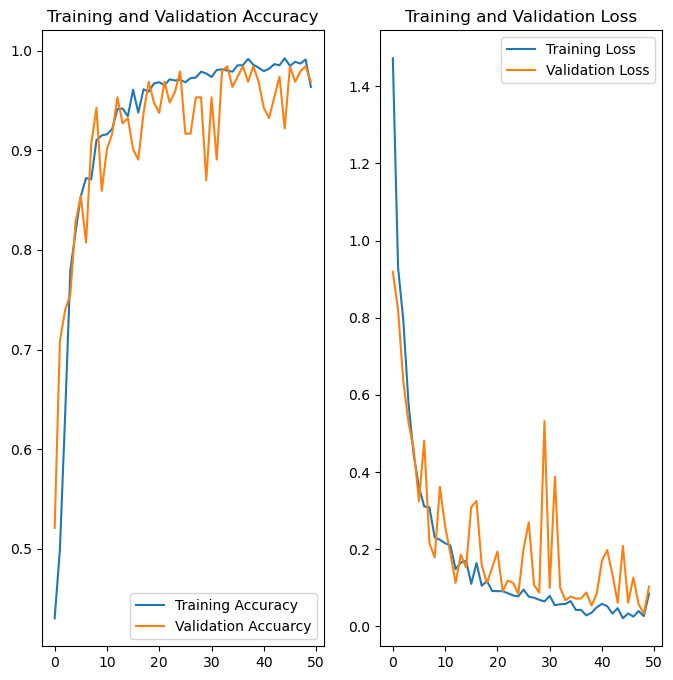

In [33]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(50), acc, label = 'Training Accuracy')
plt.plot(range(50), val_acc, label = 'Validation Accuarcy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label = 'Training Loss')
plt.plot(range(50), val_loss, label = 'Validation Loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation Loss')

plt.show()

### Running prediction on a sample image

First image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 243ms/step
predicted label: Potato___Early_blight


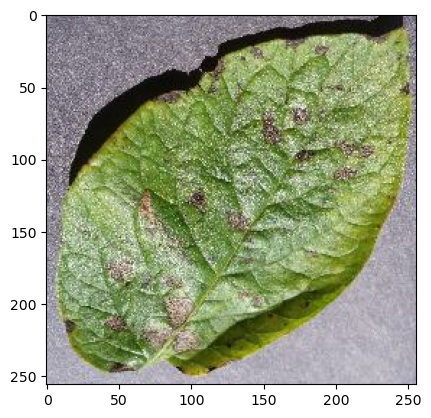

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.skip(1).take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_lable = label_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('actual label:' , class_name[first_lable])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label:',class_name[np.argmax(batch_prediction[0])])

### Writing a function for Inference

In [52]:
def predict1(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    prediced_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return prediced_class , confidence

### Running Inference on few sample images

1/1 [==============================] - 0s 34ms/step


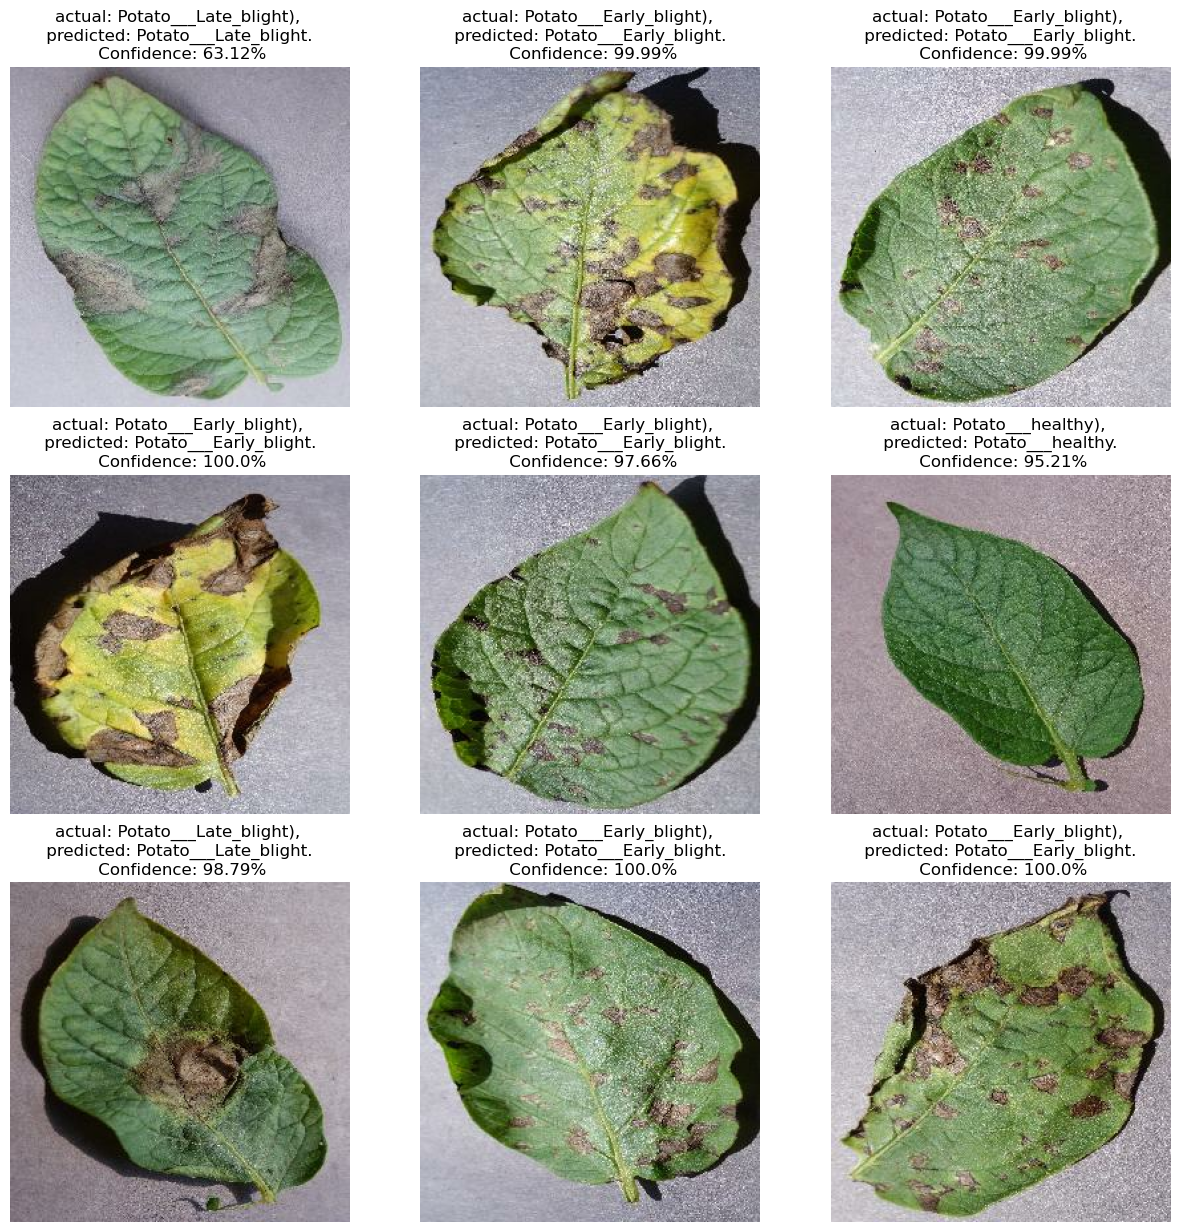

In [53]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class , confidence = predict1(model=model, img = images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f'actual: {actual_class}), \n predicted: {predicted_class}. \n Confidence: { confidence}%')
        plt.axis('off')
        

### Saving the Model

In [54]:
import os

In [59]:
#model_version = max([int(i) for i in os.listdir() + [0]]) + 1
#model.save(f'../models/{model_version}')
model.save('PlantVillage')

INFO:tensorflow:Assets written to: PlantVillage\assets


INFO:tensorflow:Assets written to: PlantVillage\assets


In [60]:
model.save('../Potato desease/models')

INFO:tensorflow:Assets written to: ../Potato desease/models\assets


INFO:tensorflow:Assets written to: ../Potato desease/models\assets


In [61]:
import pickle

In [62]:
pickle.dump(model,open('saved_model.pkl','wb'))